In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn
import os
from datetime import datetime, timedelta
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input, TimeDistributed, LeakyReLU, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,TensorBoard

/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
os.listdir('./data/')

['DJI_ema.csv',
 'DJI_STO_20period_sma10.csv',
 'DJI_modified_sma.csv',
 '.DS_Store',
 'DJI_modified_features - DJI.csv',
 'DJI_fe.csv',
 'N225withoutNULL.csv',
 'dowjone1985_2019.csv',
 'N225fillVOL.csv',
 'test_djia.csv',
 'DJI_denoise.csv',
 'N225.csv',
 'stocknews',
 'preprocessed',
 'downjone5y.csv']

In [3]:
df_nikkei = pd.read_csv('./data/N225withoutNULL.csv')
df_djia = pd.read_csv('./data/DJI_modified_sma.csv')

In [4]:
df_nikkei.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0
3,1985-02-01,11946.959961,11946.959961,11946.959961,11946.959961,11946.959961,0
4,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0


In [5]:
df_djia['Date'][0]

'1985-01-29'

# Preprocess

In [6]:
# postpone 1 day and concatenate both table

# decrement datetime of djia first
df_djia_dc = df_djia.copy()
# df_djia_dc['Date'] = df_djia['Date'] + timedelta(days=-1)
for i in tqdm(range(len(df_djia))):
    df_djia_dc['Date'][i] = str((datetime.strptime(df_djia.iloc[i]['Date'], '%Y-%m-%d') + timedelta(days=-1)).date())

# df_djia_dc.head()
df = pd.merge(df_nikkei, df_djia_dc, on='Date', how='inner')
df = df.rename({'Open_x': 'Open(Nikkei)', 'High_x': 'High(Nikkei)', 'Low_x': 'Low(Nikkei)', 'Close_x': 'Close(Nikkei)',
                'Open_y': 'Open(DJIA)', 'High_y': 'High(DJIA)', 'Low_y': 'Low(DJIA)', 'Close_y': 'Close(DJIA)'
               }, axis=1)


  0%|          | 0/8762 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 8762/8762 [00:02<00:00, 3886.43it/s]


In [7]:
df.head()

,Date,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Adj Close_x,Volume_x,Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA),Adj Close_y,Volume_y,sma5,sma10,sma25,sma75,sma125,sma200
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971
3,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0,1294.060059,1301.130005,1278.599976,1285.229980,1285.229980,13800000,1285.535986,1285.229980,1285.229980,1285.229980,1285.229980,1285.229980
4,1985-02-05,11823.429688,11823.429688,11823.429688,11823.429688,11823.429688,0,1284.890015,1294.500000,1275.069946,1280.589966,1280.589966,14610000,1284.077979,1280.589966,1280.589966,1280.589966,1280.589966,1280.589966


In [8]:
# df_djia_dc.iloc[0]['Date']

In [9]:
event_col = ['Open(Nikkei)', 'High(Nikkei)', 'Low(Nikkei)', 'Close(Nikkei)',
            'Open(DJIA)', 'High(DJIA)', 'Low(DJIA)', 'Close(DJIA)'
            ]
total_col = df.columns
for col in total_col:
    if col not in event_col:
        df = df.drop(col, axis=1)

In [10]:
df.tail()

,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA)
6906,22619.769531,22648.810547,22457.890625,22625.380859,26893.92969,26931.77930,26714.33984,26805.52930
6907,22725.439453,22780.990234,22704.330078,22750.599609,26789.60938,27015.36914,26765.67969,26958.06055
6908,22854.439453,22896.220703,22830.570313,22867.269531,27061.07031,27165.93945,27039.75977,27071.46094
6909,22950.789063,23008.429688,22935.349609,22974.130859,27110.71094,27204.35938,26999.64063,27186.68945
6910,22953.169922,22961.230469,22827.929688,22843.119141,27188.36914,27188.36914,26918.28906,27046.23047


In [11]:
def normalize_data(df, event_col):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    for col in event_col:
        if col != 'Date':
            df[col] = min_max_scaler.fit_transform(df[col].to_numpy().reshape(-1, 1))
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]
    

In [12]:
# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_norm = normalize_data(df, event_col)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (5513, 19, 8)
y_train.shape =  (5513, 8)
x_val.shape =  (689, 19, 8)
y_val.shape =  (689, 8)
x_test.shape =  (689, 19, 8)
y_test.shape =  (689, 8)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


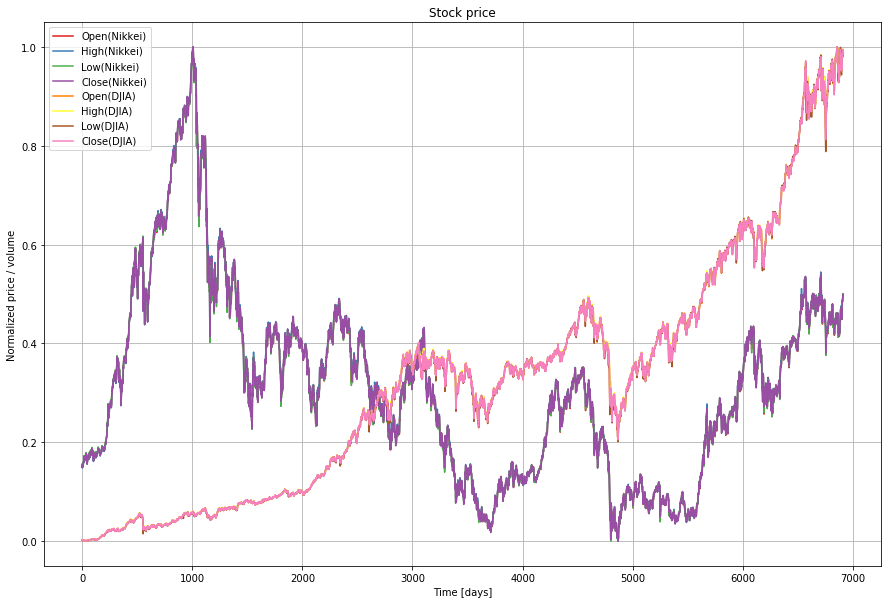

In [13]:
# plot graph before train

# !set color in graph
# color_palette = ...
plt.figure(figsize=(15, 10))
plt.grid()
color_palette = plt.get_cmap('Set1')
for i, col in enumerate(event_col):
    plt.plot(df_norm[col], color=color_palette(i), label=col)
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend()
plt.show()

# Training

In [14]:
# hyperparameter 
batch_size = 1024
epochs = 300

# set up callback_list
weight_path_model = "saved_model/model_djia_support_nikkei.h5"
tensorboard_path = 'Graph/djia_support_nikkei_1'
callbacks_list_model = [
    TensorBoard(log_dir=tensorboard_path),
    ModelCheckpoint(
            weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=1e-9)
]

In [15]:
K.clear_session()

def get_bi_gru():
    
    input1 = Input(shape=(19,8,))
    x = Bidirectional(LSTM(256, return_sequences=True,  kernel_initializer='Orthogonal'))(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = GRU(128,kernel_initializer='Orthogonal')(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    x = (Dropout(0.25))(x)
    out = Dense(8,kernel_initializer='he_normal')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(lr=1e-2, decay=1e-2),
                loss='mse',
                metrics=['mse'])   
    
    return model

model = get_bi_gru()
model.summary()
    

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 8)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 19, 512)           542720    
_________________________________________________________________
time_distributed (TimeDistri (None, 19, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 512)           2048      
_________________________________________________________________
gru (GRU)                    (None, 128)               246144    
_______________________

# Experiment and Result

In [16]:
history = model.fit(x_train, y_train, epochs=epochs , callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) 

Train on 5513 samples, validate on 689 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
5120/5513 [==========================>...] - ETA: 0s - loss: 2.7933 - mean_squared_error: 2.7933
Epoch 00001: val_loss improved from inf to 0.70757, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 6s 1ms/sample - loss: 2.6164 - mean_squared_error: 2.6164 - val_loss: 0.7076 - val_mean_squared_error: 0.7076
Epoch 2/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.1221 - mean_squared_error: 0.1221
Epoch 00002: val_loss did not improve from 0.70757
5513/5513 [==============================] - 5s 844us/sample - loss: 0.1181 - mean_squared_error: 0.1181 - val_loss: 0.7946 - val_mean_squared_error: 0.7946
Epoch 3/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 00003: val_loss did not improve from 0.70757
5513/5513

5120/5513 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 00023: val_loss improved from 0.12658 to 0.10118, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 960us/sample - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.1012 - val_mean_squared_error: 0.1012
Epoch 24/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 00024: val_loss improved from 0.10118 to 0.08710, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 945us/sample - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0871 - val_mean_squared_error: 0.0871
Epoch 25/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 00025: val_loss improved from 0.08710 to 0.07910, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [===================

Epoch 48/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 00048: val_loss improved from 0.06382 to 0.06255, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 922us/sample - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0625 - val_mean_squared_error: 0.0625
Epoch 49/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 00049: val_loss improved from 0.06255 to 0.06172, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 915us/sample - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0617 - val_mean_squared_error: 0.0617
Epoch 50/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 00050: val_loss improved from 0.06172 to 0.06027, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [======

5120/5513 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 00070: val_loss improved from 0.04719 to 0.04605, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 935us/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 71/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 00071: val_loss improved from 0.04605 to 0.04505, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 925us/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0451 - val_mean_squared_error: 0.0451
Epoch 72/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 00072: val_loss did not improve from 0.04505
5513/5513 [==============================] - 5s 930us/sample - loss: 0.0027 - mean_squared_e

Epoch 93/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 00093: val_loss improved from 0.03121 to 0.02979, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 956us/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 94/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 00094: val_loss improved from 0.02979 to 0.02854, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 938us/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 95/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 00095: val_loss improved from 0.02854 to 0.02766, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [======

Epoch 116/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 00116: val_loss improved from 0.01433 to 0.01403, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 975us/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 117/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 00117: val_loss improved from 0.01403 to 0.01273, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 921us/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 118/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 00118: val_loss improved from 0.01273 to 0.01248, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [===

Epoch 139/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 00139: val_loss did not improve from 0.00503
5513/5513 [==============================] - 5s 937us/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 140/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 00140: val_loss improved from 0.00503 to 0.00473, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 958us/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 141/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 00141: val_loss did not improve from 0.00473
5513/5513 [==============================] - 5s 941us/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0053 - val_mean_squ

Epoch 164/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 00164: val_loss improved from 0.00286 to 0.00269, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 947us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 165/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 00165: val_loss improved from 0.00269 to 0.00255, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 943us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 166/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 00166: val_loss improved from 0.00255 to 0.00254, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [===

5120/5513 [==========================>...] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 00188: val_loss did not improve from 0.00172
5513/5513 [==============================] - 5s 932us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 189/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 00189: val_loss improved from 0.00172 to 0.00167, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 940us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 190/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 00190: val_loss did not improve from 0.00167
5513/5513 [==============================] - 5s 922us/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0017 - val_mean_squared_error: 0.

5120/5513 [==========================>...] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 00213: val_loss did not improve from 0.00160
5513/5513 [==============================] - 5s 984us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 214/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 00214: val_loss did not improve from 0.00160
5513/5513 [==============================] - 6s 1ms/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 215/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 00215: val_loss improved from 0.00160 to 0.00158, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 938us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0016 - val_mean_squared_error: 0.00

Epoch 237/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 00237: val_loss improved from 0.00146 to 0.00145, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 968us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 238/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 00238: val_loss improved from 0.00145 to 0.00144, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 984us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 239/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 00239: val_loss did not improve from 0.00144
5513/5513 [==============================] - 5s 952us/sample - loss: 0.0022 

5120/5513 [==========================>...] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 00261: val_loss did not improve from 0.00140
5513/5513 [==============================] - 5s 903us/sample - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 262/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 00262: val_loss did not improve from 0.00140
5513/5513 [==============================] - 5s 918us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 263/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 00263: val_loss did not improve from 0.00140
5513/5513 [==============================] - 5s 906us/sample - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 264/300
5120/5513 [==========================>...] 

Epoch 286/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 00286: val_loss did not improve from 0.00138
5513/5513 [==============================] - 5s 937us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 287/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 00287: val_loss improved from 0.00138 to 0.00138, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 974us/sample - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 288/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 00288: val_loss improved from 0.00138 to 0.00138, saving model to saved_model/model_djia_support_nikkei.h5
5513/5513 [==============================] - 5s 933us/sample - loss: 0.0021 

In [17]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])


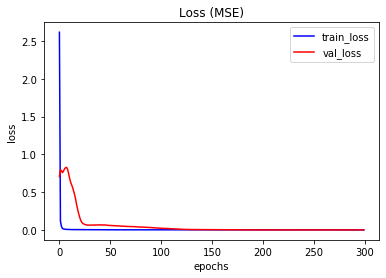

In [18]:
plt.title("Loss (MSE)")
plt.plot(history.history['loss'],color = 'blue',label="train_loss")
plt.plot(history.history['val_loss'],color = 'red',label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig('loss_support.png')

In [19]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [20]:
#fix!
def plot_compare(x, event_col):
#     Col = {'Open':0, 'High':1, 'Low':2, 'Close':3}
    Col = dict()
    count = 0
    for i, col in enumerate(event_col):
        Col[col] = i
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price :' + x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices :' + x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')



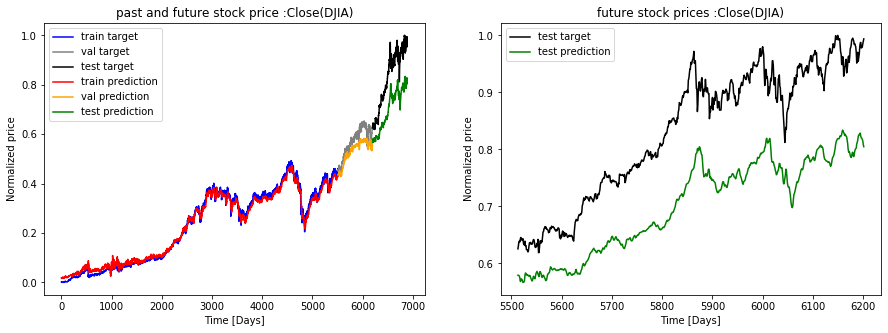

In [21]:
plot_compare('Close(DJIA)', event_col)